In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import nltk
import re
from nltk.corpus import stopwords
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import euclidean_distances
from scipy.cluster.hierarchy import ward, dendrogram,fcluster

from sklearn.cluster import DBSCAN
from sklearn import metrics

In [2]:
col_event_split = ['id','userId', 'createdAt', 'text', 'longitude', 'latitude', 'placeId', 'inReplyTo', 'placeLatitude', 'placeLongitude']

In [3]:
parse_dates = ['createdAt']

In [4]:
tweets = pd.read_csv('../twitter-swisscom/twex_event_corrected.tsv', sep="\t", encoding='utf-8', escapechar='\\', names=col_event_split, parse_dates=parse_dates, na_values='N', header=None, nrows=10000)

In [5]:
tweets.head()

,id,userId,createdAt,text,longitude,latitude,placeId,inReplyTo,placeLatitude,placeLongitude
0,9514097914,17341045,2010-02-23 05:55:51,Guuuuten Morgen! :-),7.43926,46.9489,NaN,NaN,NaN,NaN
1,9514846412,7198282,2010-02-23 06:22:40,Still the best coffee in town — at La Stanza h...,8.53781,47.3678,NaN,NaN,NaN,NaN
2,9516574359,14657884,2010-02-23 07:34:25,It has been a week or so.. and today I just co...,6.13396,46.1951,NaN,NaN,NaN,NaN
3,9516952605,14703863,2010-02-23 07:51:47,Getting ready.. http://twitpic.com/14v8gz,8.81749,47.2288,NaN,NaN,NaN,NaN
4,9517198943,14393717,2010-02-23 08:02:57,Un peu de réconfort liquide en take away après...,6.63254,46.5199,NaN,NaN,NaN,NaN


In [6]:
tweets.drop(['placeId', 'inReplyTo'], inplace=True, axis=1)

Different informations on the longitude and latitude are given, the columns longitude/latitude are the position of the Tweet as reported by the user or client application. The place longitude/latitude is  indicates that the tweet is associated (but not necessarily originating from) a Place. And as we can see on the head of the table, the place is not always set.

We decided to use the longitude/latitude columns to represent the position of a tweet and if they are null we will use the placeLatitude and placeLongitude. If both are null we will have to drop the entry as a tweet without position is not usefull for event detection.

In [7]:
tweets.dtypes

id                         int64
userId                     int64
createdAt         datetime64[ns]
text                      object
longitude                float64
latitude                 float64
placeLatitude            float64
placeLongitude           float64
dtype: object

In [8]:
"""
Check if the longitude and latitude are set. 
If not, check for the place latitude and longitude and replace.
If not, drop the row
"""
def find_position(row):
    if(np.isnan(row['longitude'])) and (not np.isnan(row['placeLongitude'])):
        row['longitude'] = row['placeLongitude']
    if(not(np.isnan(row['longitude'])) and np.isnan(row['latitude']) and (not np.isnan(row['placeLatitude']))):
        row['latitude'] = row['placeLatitude']
    return row

In [9]:
tweets = tweets.apply(find_position, axis=1)

In [10]:
tweets.head()

,id,userId,createdAt,text,longitude,latitude,placeLatitude,placeLongitude
0,9514097914,17341045,2010-02-23 05:55:51,Guuuuten Morgen! :-),7.43926,46.9489,NaN,NaN
1,9514846412,7198282,2010-02-23 06:22:40,Still the best coffee in town — at La Stanza h...,8.53781,47.3678,NaN,NaN
2,9516574359,14657884,2010-02-23 07:34:25,It has been a week or so.. and today I just co...,6.13396,46.1951,NaN,NaN
3,9516952605,14703863,2010-02-23 07:51:47,Getting ready.. http://twitpic.com/14v8gz,8.81749,47.2288,NaN,NaN
4,9517198943,14393717,2010-02-23 08:02:57,Un peu de réconfort liquide en take away après...,6.63254,46.5199,NaN,NaN


We can now drop the columns placeLongitude and placeLatitude as they don't give us anymore informations.

In [11]:
tweets.drop(['placeLatitude', 'placeLongitude'],inplace=True, axis=1)

Then we drop the NaN values in Longitude and Latitude columns as we need a position to detect event.

In [12]:
len_before = len(tweets.index)
tweets = tweets.dropna(subset=['longitude', 'latitude'])
len_after = len(tweets.index)
print("Number of tweets before dropping the one without position : ", len_before)
print("Number of tweets before dropping the one without position : ", len_after)
print("Percentage of tweets lost : ", ((len_before - len_after)/len_before)*100)

Number of tweets before dropping the one without position :  10000
Number of tweets before dropping the one without position :  10000
Percentage of tweets lost :  0.0


We want to detect the event from the tweets we now extracted. To do so we had to do some assumptions. We decided to work with the text to find event. 
- Hashtags can be a good estimators of what event were on at the time of the tweets.
- Events can take place on several days but we will decide to take tweets day per day.

As we decided to detect an event by its day of occurence we create a new column that gives us the information of the day.

In [13]:
tweets['day'] = pd.DatetimeIndex(tweets['createdAt']).normalize()

In [14]:
tweets['month'] = tweets['createdAt'].map(lambda x: str(x.year) + "-" + str(x.month))

We decide to remove the stopwords from the tweets' text to keep only words that can describe an event.

In [15]:
stop_words = stopwords.words('english')
stop_words += stopwords.words('french')
stop_words += stopwords.words('german')
stop_words += stopwords.words('italian')
stop_words += string.punctuation
stop_words += ['—','/via','^_^', ':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
    ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
    ':c', ':{', '>:\\', ';(', ':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
    ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
    '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
    'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)',
    '<3']

We remove the stopwords but we also remove the URLs and the @ mentions as they are not useful to detect events

In [16]:
def text_process(row):
    text = row['text']
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"@ \S+", "", text)
    text = re.sub(r"@\S+", "", text)
    text = text.split()
    text  = [word for word in text if word.lower() not in stop_words]
    row['text'] = text
    return row

In [17]:
tweets = tweets.apply(text_process, axis=1)
tweets.head()

,id,userId,createdAt,text,longitude,latitude,day,month
0,9514097914,17341045,2010-02-23 05:55:51,"[Guuuuten, Morgen!]",7.43926,46.9489,2010-02-23,2010-2
1,9514846412,7198282,2010-02-23 06:22:40,"[Still, best, coffee, town, Stanza]",8.53781,47.3678,2010-02-23,2010-2
2,9516574359,14657884,2010-02-23 07:34:25,"[week, so.., today, couldn't, focus, Sportif, ...",6.13396,46.1951,2010-02-23,2010-2
3,9516952605,14703863,2010-02-23 07:51:47,"[Getting, ready..]",8.81749,47.2288,2010-02-23,2010-2
4,9517198943,14393717,2010-02-23 08:02:57,"[peu, réconfort, liquide, take, away, après, d...",6.63254,46.5199,2010-02-23,2010-2


Now that the words should be clean we can find occurences of the same word on the same day and find event from there.
We will create list with words still in the 'text' field and we also drop the row where the text is empty.

In [18]:
tweets.dropna(subset=['text'], inplace=True)

Now that the text is pretty much clean we want to get the hashtags from the tweets because they are really helpful to detect the events. So we create a column with the hashtags :

In [19]:
def find_hashtags(texts):
    hashtags = []
    for i in range(0,len(texts)):
        if texts[i][0] in '#':
            hashtags.append(texts[i][1:])
    return hashtags

In [20]:
tweets['hashtags'] = tweets['text'].apply(find_hashtags)

In [21]:
tweets.head()

,id,userId,createdAt,text,longitude,latitude,day,month,hashtags
0,9514097914,17341045,2010-02-23 05:55:51,"[Guuuuten, Morgen!]",7.43926,46.9489,2010-02-23,2010-2,[]
1,9514846412,7198282,2010-02-23 06:22:40,"[Still, best, coffee, town, Stanza]",8.53781,47.3678,2010-02-23,2010-2,[]
2,9516574359,14657884,2010-02-23 07:34:25,"[week, so.., today, couldn't, focus, Sportif, ...",6.13396,46.1951,2010-02-23,2010-2,[]
3,9516952605,14703863,2010-02-23 07:51:47,"[Getting, ready..]",8.81749,47.2288,2010-02-23,2010-2,[]
4,9517198943,14393717,2010-02-23 08:02:57,"[peu, réconfort, liquide, take, away, après, d...",6.63254,46.5199,2010-02-23,2010-2,[]


In [22]:
def remove_hashtags(texts):
    nothashtags = []
    for i in range(0,len(texts)):
        if texts[i][0] not in '#':
            nothashtags.append(texts[i])
        else:
            nothashtags.append(texts[i][1:])
    return nothashtags

In [23]:
tweets['text'] = tweets['text'].apply(remove_hashtags)

## EVENT  DETECTION

Now that our dataframe is clean we want to find the event hidden in all those tweets. Here are our assumptions to find an event :
- An event is described by a list of words (hashtags are also used with greater importance than other words)
- An event takes place at a certain place described by longitude/latitude (we took around 10km)
- An event occurs during a certain  time (we decided to find them day by day)
- An event has a minimum number of people talking about it (we took 3) and a minimum of tweets (we took 5)

In [24]:
days = np.unique(tweets['day'].values)

In [25]:
day = tweets[tweets['day']==days[2]]

In [26]:
meters = 10000
eps = meters / 100000 # meters to degree
print(eps)

0.1


In [27]:
X = day.as_matrix(columns=['latitude', 'longitude'])
db = DBSCAN(eps=eps, min_samples=5).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

In [28]:
day['cluster'] = db.labels_

C:\Users\Alain\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [29]:
#Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)


Estimated number of clusters: 3


C:\Users\Alain\Anaconda3\lib\site-packages\matplotlib\lines.py:1145: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


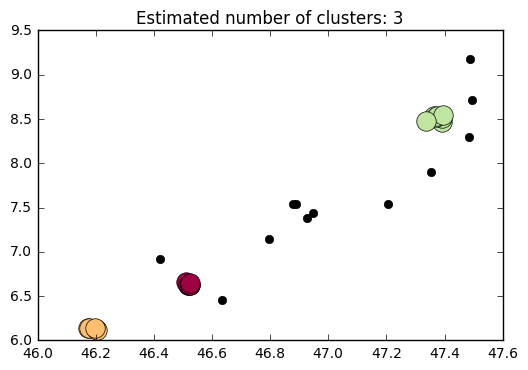

In [30]:
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

## Text analysis to detect events

We go through the clusters and find out if the corresponding tweets are linked by an event or not. To do so we first of all create a dataframe that will contain the events. (Event name, Event keywords, Event hashtags, Event longitude/latitude, Number of tweets, Number of people)

In [73]:
df_event = pd.DataFrame(columns=['name', 'keywords', 'hashtags', 'longitude', 'latitude', '# of tweets', '# of people'])

Now we want to populate our dataframe with real event. So we go through all the clusters and find out the hashtags, keywords and corresponding event based on these two infos

In [96]:
def find_hashtags(df, ncluster):
    toprint = "Hashtags : "
    d = {}
    for hashtags_ in df[df['cluster']==ncluster].hashtags:
        if(hashtags_!=[]):
            for hashtag in hashtags_:
                if hashtag in d:
                    d[hashtag]+=1
                else:
                    d[hashtag]=1
    for elem in d:
        toprint += "#" + elem + " -> " + str(d[elem]) + "\n"
            
    print(toprint + "\n")
    return d

In [101]:
def find_keywords(df, ncluster):
    toprint="Keywords : "
    nb_tweets = len(day[day['cluster']==cluster])
    d = {}
    for text_ in df[df['cluster']==ncluster].text:
        for word in text_:
                if word in d:
                    d[word]+=1
                else:
                    d[word]=1
    for elem in d:
        if(d[elem]>nb_tweets/2):
            toprint += elem + " -> " + str(d[elem]) + "\n"
            
    print(toprint + "\n")
    return d

In [102]:
for cluster in range(0,n_clusters_-1):
    print("Cluster n°" + str(cluster) + "( " + str(len(day[day['cluster']==cluster])) + " tweets" + " )" " : ")
    d_hashtags = find_hashtags(day, cluster)
    d_keywords = find_keywords(day, cluster)
    
    
    

Cluster n°0( 8 tweets ) : 
Hashtags : 

Keywords : 

Cluster n°1( 6 tweets ) : 
Hashtags : #fb -> 2


Keywords : 



In [ ]:
def Most_Common(lst, limit):
    flatten = [val.lower() for sublist in lst for val in sublist]
    vocabulary = []
    data = Counter(flatten)
    for elem in data.most_common(len(flatten)):
        if(elem[1] >= limit):
            vocabulary.append(elem[0])
    return vocabulary

In [ ]:
vocab = Most_Common(day['text'], 4)
print(vocab)

In [ ]:
month = tweets[tweets['month']=='2010-2']
month.head()

First of all we will constitute a vocabulary containing the words that are often used in the tweets. To do so we go through all the texts and for each term we count the number of occurences and then keep only the one that are often used.

In [ ]:
vocab = Most_Common(month['text'], 3)
print(len(vocab))

To this vocabulary we add all the hashtags we detected before as they are important words anyway

In [ ]:
for list_ in np.unique(month['hashtags'][month['hashtags']!=""].values):
    for tag in list_:
        if(tag not in vocab):
            vocab.append(tag)
print(len(vocab))

The idea after that is to create a matrix containing the tweets on an axis and the terms on another and add a 1 in the cell where the current words appears in the current tweet's text.

In [ ]:
tweets_text = []
for list_ in month['text']:
    text = ""
    for i in range(0,len(list_)):
        text += list_[i]+ " "
    tweets_text.append(text)

Create the tweet-term matrix

In [ ]:
vec = CountVectorizer(vocabulary=vocab)
ttm = vec.fit_transform(tweets_text).toarray()

Now we want to take the distance between the tweets

In [ ]:
dist_eucl = euclidean_distances(ttm)
np.round(dist_eucl,1)

In [ ]:
n_tweets = dist_eucl.shape[0]

In [ ]:
linkage_matrix = ward(dist_eucl)

dendrogram(linkage_matrix, orientation="left")

plt.tight_layout()  # fixes margins

plt.show()

In [ ]:
cluster = fcluster(Z=linkage_matrix, t=0.0001)      

In [ ]:
import collections
d={}
for tweetid, clusterid in enumerate(cluster):
    if not clusterid in d: d[clusterid]=[]
    d[clusterid].append(tweetid)
print(d)

In [ ]:
cluster_df = pd.DataFrame(columns=['text', 'tweetids'])
cluster_df['text'] = []
cluster_df['tweetids'] = []

In [ ]:
rows_list = []
for key, values in d.items():
    text =set()
    ids=[]
    for value in values:
        for word in month['text'][value]:
            text.add(word) 
        ids.append(month['id'][value])
        
    dict1 = {'text':list(text), 'tweetids':ids}

    rows_list.append(dict1)

df = pd.DataFrame(rows_list) 
df

Now that potential events are detected, we will first of all keep only event with at least 5 tweets talking about it and then we will look if there are at least 3 different users.

In [ ]:
for index in range(0,len(df)):
    if len(df['tweetids'][index])<5:
        df.drop(index, inplace=True)    

In [ ]:
df.reset_index(drop=True)

In [ ]:
month.set_index('id', inplace=True)

In [ ]:
df.reset_index(inplace=True, drop=True)

In [ ]:
for index in range(0,len(df)):
    users=[]
    for tweetid in df['tweetids'][index]:
        users.append(month['userId'][tweetid])
    if(len(users) < 3):
        df.drop(index, inplace=True)
df
        

So now we have that these events are described by at least 5 tweets and at least 3 users. We will now take a look at the position of those tweets and see if they are physical event or just trending tweets.

In [ ]:
minlongitude = []
maxlongitude = []
minlatitude = []
maxlatitude = []
for index in range(0,len(df)):
    minlong = 50
    minlat = 50
    maxlong = 0
    maxlat = 0
    for tweetid in df['tweetids'][index]:
        if(month['longitude'][tweetid] < minlong):
            minlong=month['longitude'][tweetid]
        if(month['longitude'][tweetid] > maxlong):
            maxlong=month['longitude'][tweetid]
        if(month['latitude'][tweetid] < minlat):
            minlat=month['latitude'][tweetid]
        if(month['latitude'][tweetid] > maxlat):
            maxlat=month['latitude'][tweetid]
        
    minlongitude.append(minlong)
    maxlongitude.append(maxlong)
    minlatitude.append(minlat)
    maxlatitude.append(maxlat)

df['minlongitude'] = minlongitude
df['maxlongitude'] = maxlongitude
df['minlatitude'] = minlatitude
df['maxlatitude'] = maxlatitude
df
        

In [ ]:
len(df['tweetids'][0])

In [ ]:
df['text'][1]

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
dist_cosine = 1 - cosine_similarity(ttm)

In [ ]:
np.round(dist_cosine, 2)

In [ ]:
from scipy.cluster.hierarchy import ward, dendrogram
import matplotlib.pyplot as plt

linkage_matrix = ward(dist_cosine)

dendrogram(linkage_matrix, orientation="left")

plt.tight_layout()  # fixes margins

plt.show()